In [1]:
# in JupyterHub, plot difference in DT across globe between VIIRS and L3S
# HealPix
# once you can get geographic plots to work, everything else is just changing what you want to plot

In [3]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import healpy as hp
# os.path.expanduser("~")

In [4]:
# read in 2012 h5 file

analysis_table = pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

In [5]:
analysis_table.columns[[20,21]]

Index(['lat', 'lon'], dtype='object')

In [6]:
analysis_table.columns[[3,37]]

Index(['VIIRS_LL', 'LL'], dtype='object')

In [7]:
analysis_table[['VIIRS_datetime', 'datetime']]

,VIIRS_datetime,datetime
0,2012-02-01 00:10:00,2012-01-31 13:42:26
1,2012-02-01 00:10:00,2012-01-31 13:44:47
2,2012-02-01 00:10:00,2012-01-31 13:49:19
3,2012-02-01 00:10:00,2012-01-31 13:46:48
4,2012-02-01 00:10:00,2012-01-31 13:44:00
...,...,...
293937,2012-12-31 23:20:00,2012-12-31 04:04:45
293938,2012-12-31 23:20:00,2012-12-31 03:48:18
293939,2012-12-31 23:20:00,2012-12-31 03:47:34
293940,2012-12-31 23:20:00,2012-12-31 03:46:52


In [8]:
file_path = '/home/jovyan/L3S_VIIRS144_2012_preproc.h5'
with h5py.File(file_path, "r") as h5:
    data = h5['valid'][:]
    metadata = h5['valid_metadata'][:]

In [9]:
cutout_indices = metadata[:, [8, 20, 21, 33, 34]]
decoded_data = [[float(item.decode('utf-8')) for item in row] for row in cutout_indices]
column_names = ['VIIRS_DT', 'lat', 'lon', 'T90', 'T10']
df = pandas.DataFrame(decoded_data, columns = column_names)

df.loc[:,'DT'] = df.loc[:,'T90'] - df.loc[:,'T10']

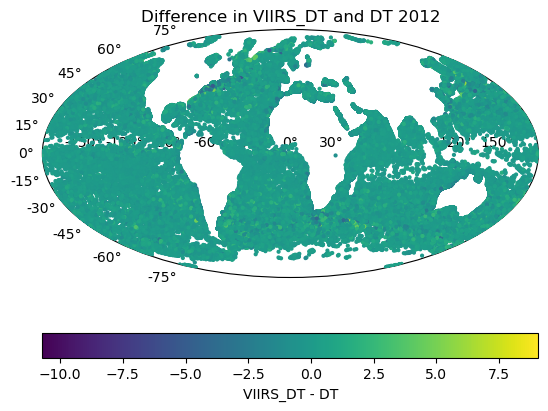

In [193]:
# this makes a plot of DT difference using the h5 file

nside = 8
npix = hp.nside2npix(nside)

num_cutouts = len(df)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
dt_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    viirs_dt = float(df.iloc[i, 0])
    lat = float(df.iloc[i, 1])
    lon = float(df.iloc[i, 2])
    dt = float(df.iloc[i, 5])

    center_lat_values[i] = lat
    center_lon_values[i] = lon

    dt_values[i] = viirs_dt - dt

hp_map = np.zeros(npix)
for i in range(npix):
    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])
fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})
im = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10)
# hp.cartview(hp_map, cmap='viridis', lonra=[-180, 180], latra=[-90, 90], cbar=False, hold=True)
ax.set_title('Difference in VIIRS_DT and DT 2012')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label('VIIRS_DT - DT')

plt.show()

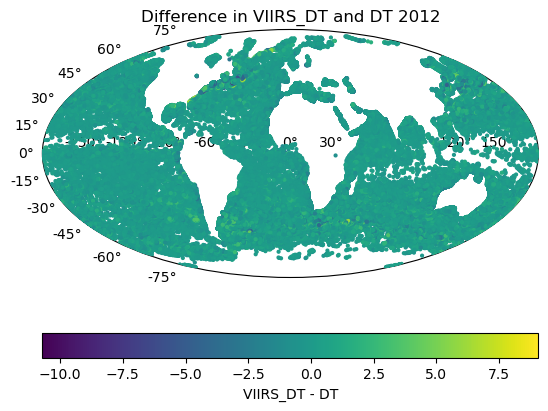

In [68]:
# this makes plot of DT difference using analyis table
# I am only plotting a point at the lat/lon, so it doesn't matter which method right now but the h5 does not have LL so good to have both methods

nside = 8
npix = hp.nside2npix(nside)

cutout_indices = analysis_table.iloc[:, [8, 20, 21, 36]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
dt_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    viirs_dt = float(cutout_indices.iloc[i, 0])
    lat = float(cutout_indices.iloc[i, 1])
    lon = float(cutout_indices.iloc[i, 2])
    dt = float(cutout_indices.iloc[i, 3])

    center_lat_values[i] = lat
    center_lon_values[i] = lon

    dt_values[i] = viirs_dt - dt
    
hp_map = np.zeros(npix)
for i in range(npix):
    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])

fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})
im = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10)
ax.set_title('Difference in VIIRS_DT and DT 2012')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label('VIIRS_DT - DT')

plt.show()

In [11]:
# look at difference in DT

cutout_indices = analysis_table.iloc[:, [8, 20, 21, 36]]
cutout_indices.loc[:,'diff_dt'] = cutout_indices.loc[:,'VIIRS_DT'] - cutout_indices.loc[:,'DT']

print("Minimum value:", np.min(cutout_indices.loc[:,'diff_dt']))
print("Maximum value:", np.max(cutout_indices.loc[:,'diff_dt']))
print("Mean:", np.mean(cutout_indices.loc[:,'diff_dt']))
print("Standard Deviation:", np.std(cutout_indices.loc[:,'diff_dt']))

Minimum value: -10.709991455078125
Maximum value: 9.07000732421875
Mean: 0.10928955424229445
Standard Deviation: 0.8288329603954461


/tmp/ipykernel_226/2307269794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutout_indices.loc[:,'diff_dt'] = cutout_indices.loc[:,'VIIRS_DT'] - cutout_indices.loc[:,'DT']


In [12]:
diff_dt = cutout_indices.loc[:,'diff_dt']
threshold = np.mean(diff_dt) + 3 * np.std(diff_dt)
filtered_values = diff_dt[diff_dt > threshold]
# np.mean(filtered_values) # most of the values are between the 2nd and 3rd deviations above mean
# filtered_values
# 3063 below three sds, 2052 above
# VIIRS_DT is more likely to be smaller ? 

In [13]:
# cutout with largest difference: -10.7099

cutout_indices.loc[:,'diff_dt'] = cutout_indices.loc[:,'VIIRS_DT'] - cutout_indices.loc[:,'DT']

close_ex = cutout_indices.loc[8]
# far_ex = cutout_indices.loc[cutout_indices['diff_dt'] < -10.7]
far_ex = cutout_indices.loc[94852]

In [14]:
# this is example with high difference in DT

pp_file = "s3://sst-l3s/PreProc/L3S_VIIRS144_2012_preproc.h5"
pp_idx = 5105

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
L3S_far_ex = image_utils.grab_image(matching_row, local_file = "/home/jovyan/L3S_VIIRS144_2012_preproc.h5")
#L3S_far_ex = np.flipud(np.fliplr(L3S_row0))[0,...]
L3S_far_ex = L3S_far_ex[0,...]

# get matching VIIRS
pp_file = "s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5"
pp_idx = 132767 # these cannot be simply read into the function because now they start with VIIRS_ so do not match

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
VIIRS_far_ex = image_utils.grab_image(matching_row, local_file = "/Users/rachelstumpf/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5")
VIIRS_far_ex = VIIRS_far_ex[0,...]

NameError: name 'L3S_row0' is not defined

In [ ]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(None, None), show=False, set_aspect=None, clbl=None,
               ax=None, title=None):
    """Display the cutout image
    Args:
        img (np.ndarray): cutout image
        cm ([type], optional): Color map to use. Defaults to None.
            If None, load the heatmap above
        cbar (bool, optional): If True, show a color bar. Defaults to True.
        flipud (bool, optional): If True, flip the image up/down. Defaults to True.
        vmnx (tuple, optional): Set vmin, vmax. Defaults to None
        set_aspect (str, optional):
            Passed to ax.set_aspect() if provided
        ax (matplotlib.Axis, optional): axis to use for the plot
        title (str, optional): title for the plot
    Returns:
        matplotlib.Axis: axis containing the plot
    """
    if cm is None:
        _, cm = plotting.load_palette()
    #
    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})  # 'fontsize': 20})
    # Set the title
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    #
    return ax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Calculate the minimum and maximum values for both images
viirs_min = np.min(VIIRS_far_ex)
viirs_max = np.max(VIIRS_far_ex)
l3s_min = np.min(L3S_far_ex[0])
l3s_max = np.max(L3S_far_ex[0])

# Use the same vmin and vmax for both images
vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))

show_image(VIIRS_far_ex, ax=axes[0], title='VIIRS', vmnx=vmnx)

show_image(L3S_far_ax, ax=axes[1], title='L3S', vmnx=vmnx)

plt.show()

In [ ]:
# this is example with low difference in DT

pp_file = "s3://sst-l3s/PreProc/L3S_VIIRS144_2012_preproc.h5"
pp_idx = 162037

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
L3S_close_ex = image_utils.grab_image(matching_row, local_file = "/home/jovyan/L3S_VIIRS144_2012_preproc.h5")
#L3S_far_ex = np.flipud(np.fliplr(L3S_row0))[0,...]
L3S_close_ex = L3S_far_ex[0,...]

# get matching VIIRS
pp_file = "s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5"
pp_idx = 8477 # these cannot be simply read into the function because now they start with VIIRS_ so do not match

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
VIIRS_close_ex = image_utils.grab_image(matching_row, local_file = "/Users/rachelstumpf/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5")
VIIRS_close_ex = VIIRS_close_ex[0,...]

In [ ]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(None, None), show=False, set_aspect=None, clbl=None,
               ax=None, title=None):
    """Display the cutout image
    Args:
        img (np.ndarray): cutout image
        cm ([type], optional): Color map to use. Defaults to None.
            If None, load the heatmap above
        cbar (bool, optional): If True, show a color bar. Defaults to True.
        flipud (bool, optional): If True, flip the image up/down. Defaults to True.
        vmnx (tuple, optional): Set vmin, vmax. Defaults to None
        set_aspect (str, optional):
            Passed to ax.set_aspect() if provided
        ax (matplotlib.Axis, optional): axis to use for the plot
        title (str, optional): title for the plot
    Returns:
        matplotlib.Axis: axis containing the plot
    """
    if cm is None:
        _, cm = plotting.load_palette()
    #
    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})  # 'fontsize': 20})
    # Set the title
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    #
    return ax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Calculate the minimum and maximum values for both images
viirs_min = np.min(VIIRS_close_ex)
viirs_max = np.max(VIIRS_close_ex)
l3s_min = np.min(L3S_close_ex[0])
l3s_max = np.max(L3S_close_ex[0])

# Use the same vmin and vmax for both images
vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))

show_image(VIIRS_close_ex, ax=axes[0], title='VIIRS', vmnx=vmnx)

show_image(L3S_close_ex, ax=axes[1], title='L3S', vmnx=vmnx)

plt.show()

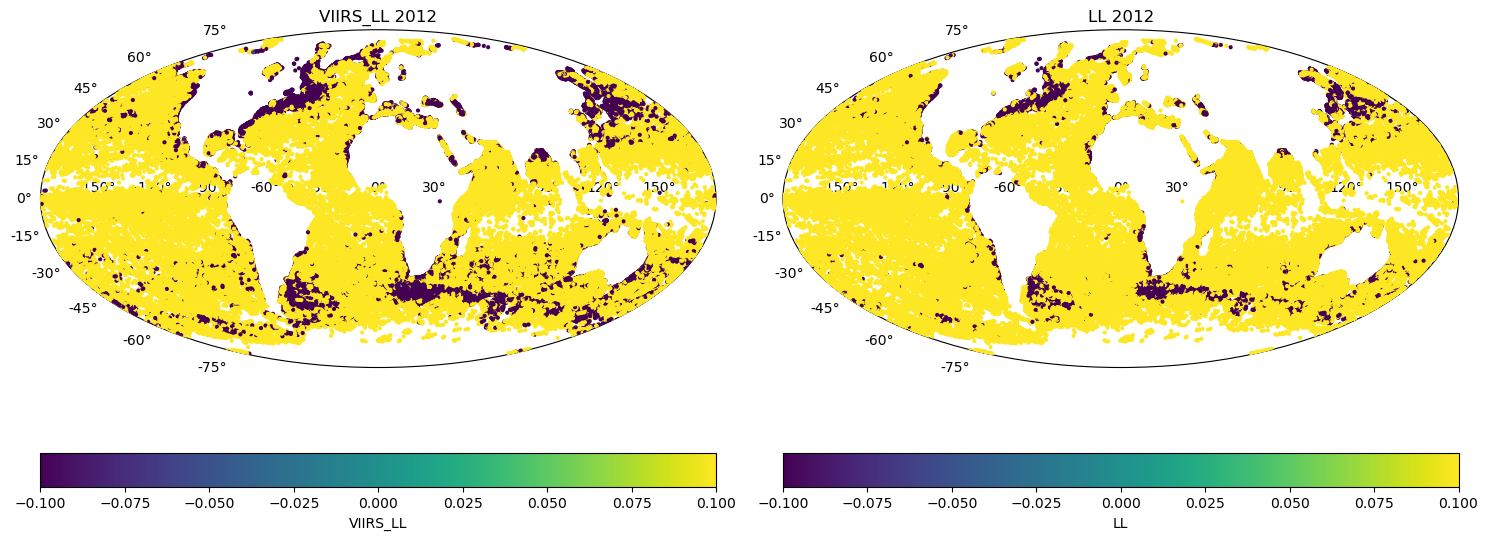

In [239]:
# plot log likelihoods side by side

nside = 8
npix = hp.nside2npix(nside)

cutout_indices = analysis_table.iloc[:, [20, 21, 3, 37]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
viirs_ll_values = np.zeros(num_cutouts)
ll_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    lat = cutout_indices.iloc[i,0]
    lon = cutout_indices.iloc[i,1]
    viirs_ll = cutout_indices.iloc[i,2]
    ll  = cutout_indices.iloc[i,3]
    
    center_lat_values[i] = lat
    center_lon_values[i] = lon
    viirs_ll_values[i] = viirs_ll
    ll_values[i] = ll
    
combined_values = np.concatenate((viirs_ll_values, ll_values))
vmin = np.min(combined_values)
vmax = np.max(combined_values)

viirs_ll_map = np.zeros(npix)
ll_map = np.zeros(npix)
for i in range(npix):
    viirs_ll_map[i] = np.mean(viirs_ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])
    ll_map[i] = np.mean(ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': 'mollweide'})

im1 = ax1.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=viirs_ll_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin=vmin, vmax=vmax)
ax1.set_title('VIIRS_LL 2012')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal')
cbar1.set_label('VIIRS_LL')

im2 = ax2.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=ll_values, cmap='viridis', s=4, linewidth=1, zorder=10,vmin=vmin, vmax=vmax)
ax2.set_title('LL 2012')
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal')
cbar2.set_label('LL')

plt.tight_layout()
plt.show()

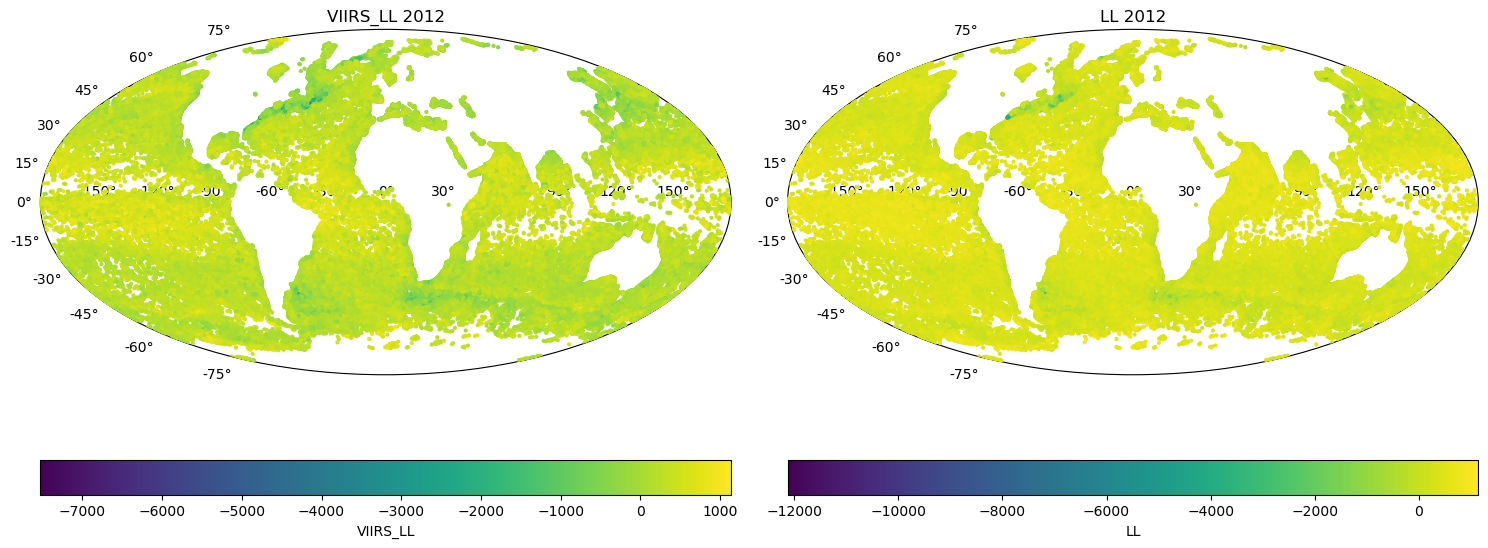

In [243]:
# plot log likelihoods side by side

nside = 8
npix = hp.nside2npix(nside)

cutout_indices = analysis_table.iloc[:, [20, 21, 3, 37]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
viirs_ll_values = np.zeros(num_cutouts)
ll_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    lat = cutout_indices.iloc[i,0]
    lon = cutout_indices.iloc[i,1]
    viirs_ll = cutout_indices.iloc[i,2]
    ll  = cutout_indices.iloc[i,3]
    
    center_lat_values[i] = lat
    center_lon_values[i] = lon
    viirs_ll_values[i] = viirs_ll
    ll_values[i] = ll

viirs_ll_map = np.zeros(npix)
ll_map = np.zeros(npix)
for i in range(npix):
    viirs_ll_map[i] = np.mean(viirs_ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])
    ll_map[i] = np.mean(ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': 'mollweide'})

im1 = ax1.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=viirs_ll_values, cmap='viridis', s=4, linewidth=1, zorder=10)
ax1.set_title('VIIRS_LL 2012')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal')
cbar1.set_label('VIIRS_LL')

im2 = ax2.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=ll_values, cmap='viridis', s=4, linewidth=1, zorder=10)
ax2.set_title('LL 2012')
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal')
cbar2.set_label('LL')

plt.tight_layout()
plt.show()

In [236]:
print("VIIRS Minimum value:", np.min(analysis_table.loc[:,'VIIRS_LL']))
print("VIIRS Maximum value:", np.max(analysis_table.loc[:,'VIIRS_LL']))
print("VIIRS Mean:", np.mean(analysis_table.loc[:,'VIIRS_LL']))
print("VIIRS Standard Deviation:", np.std(analysis_table.loc[:,'VIIRS_LL']))

print("L3S Minimum value:", np.min(analysis_table.loc[:,'LL']))
print("L3S Maximum value:", np.max(analysis_table.loc[:,'LL']))
print("L3S Mean:", np.mean(analysis_table.loc[:,'LL']))
print("L3S Standard Deviation:", np.std(analysis_table.loc[:,'LL']))

Minimum value: -7527.6396484375
Maximum value: 1136.343017578125
Mean: 236.72816
Standard Deviation: 286.133056640625
Minimum value: -12129.490234375
Maximum value: 1142.1265869140625
Mean: 307.61035079559497
Standard Deviation: 302.9994250357969


<Axes: >

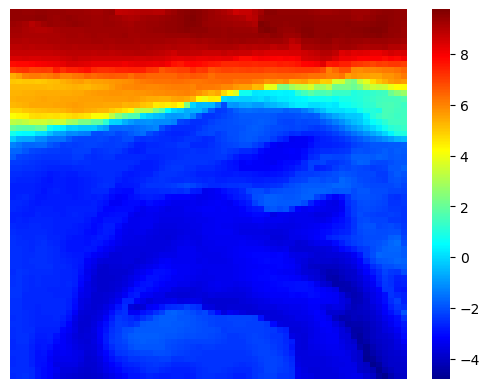

In [18]:
# this is example with high difference in DT

pp_file = "s3://sst-l3s/PreProc/L3S_VIIRS144_2012_preproc.h5"
pp_idx = 5105

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
L3S_far_ex = image_utils.grab_image(matching_row, local_file = "/home/jovyan/L3S_VIIRS144_2012_preproc.h5")
#L3S_far_ex = np.flipud(np.fliplr(L3S_row0))[0,...]
show_image(L3S_far_ex[0,...])

<Axes: >

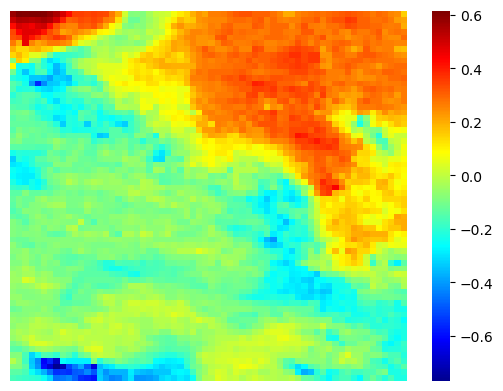

In [20]:
pp_file = "s3://sst-l3s/PreProc/L3S_VIIRS144_2012_preproc.h5"
pp_idx = 162037

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
L3S_close_ex = image_utils.grab_image(matching_row, local_file = "/home/jovyan/L3S_VIIRS144_2012_preproc.h5")
show_image(L3S_close_ex[0,...])